In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils import data

from tqdm.notebook import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

device = torch.device("mps" if torch.has_mps else "cpu")
print(device)
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from aif360.algorithms.postprocessing import (CalibratedEqOddsPostprocessing,
                                              EqOddsPostprocessing,
                                              RejectOptionClassification)
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
random_state = 1

mps


pip install 'aif360[AdversarialDebiasing]'


In [2]:
# read in data and split
X = torch.load('inputs/bfw_senet50_face_embeddings.pt').cpu()
y = torch.load('inputs/bfw_senet50_labels.pt').cpu()
df = pd.read_csv('inputs/bfw_senet50_df.csv')
gender = df['reference_gender']
df

,reference_identity,candidate_identity,reference_ethnicity,candidate_ethnicity,reference_gender,candidate_gender,labels
0,n004721,n004721,asian,asian,male,male,1.0
1,n004721,n004721,asian,asian,male,male,1.0
2,n004721,n004721,asian,asian,male,male,1.0
3,n004721,n004721,asian,asian,male,male,1.0
4,n004721,n004721,asian,asian,male,male,1.0
...,...,...,...,...,...,...,...
38395,n003412,n005685,white,white,male,male,0.0
38396,n008917,n008839,black,black,female,female,0.0
38397,n008452,n008150,asian,asian,male,male,0.0
38398,n004936,n002509,asian,asian,female,female,0.0


In [3]:
train_split, test_split = train_test_split(np.arange(len(X)),test_size=0.2, random_state=random_state)
train_split, val_split = train_test_split(train_split,test_size=0.25, random_state=random_state)

train_X = X[train_split]
X_val = X[val_split]
test_X = X[test_split]

train_y = y[train_split]
y_val = y[val_split]
test_y = y[test_split]

train_df = df.iloc[train_split]
val_df = df.iloc[val_split]
test_df = df.iloc[test_split]


train_gender = gender[train_split].values
train_gender[train_gender=='male'] = 0
train_gender[train_gender=='female'] = 1
train_gender = train_gender.astype(int)

gender_val = gender[val_split].values
gender_val[gender_val=='male'] = 0
gender_val[gender_val=='female'] = 1
gender_val = gender_val.astype(int)

test_gender = gender[test_split].values
test_gender[test_gender=='male'] = 0
test_gender[test_gender=='female'] = 1
test_gender = test_gender.astype(int)

In [4]:
train_matches = train_df[train_df.labels==1]
train_non_matches = train_df[train_df.labels==0]
print('non matches')
print(train_non_matches['reference_gender'].value_counts())
print('matches')
print(train_matches['reference_gender'].value_counts())

female_non_matches = train_non_matches[train_non_matches['reference_gender']=='female']
male_non_matches = train_non_matches[train_non_matches['reference_gender']=='male']

female_matches = train_matches[train_matches['reference_gender']=='female']
male_matches = train_matches[train_matches['reference_gender']=='male']

non matches
female    5804
male      5675
Name: reference_gender, dtype: int64
matches
female    5809
male      5752
Name: reference_gender, dtype: int64


In [5]:
np.random.seed(random_state)
female_matches_sub_idx = female_matches.index[np.random.choice(len(female_matches.index), size=5675, replace=False)]
male_matches_sub_idx = male_matches.index[np.random.choice(len(male_matches.index), size=5675, replace=False)]
female_non_matches_sub_idx = female_non_matches.index[np.random.choice(len(female_non_matches.index), size=5675, replace=False)]
male_non_matches_sub_idx = male_non_matches.index

X_train = torch.cat([X[female_matches_sub_idx],X[male_matches_sub_idx],X[female_non_matches_sub_idx],X[male_non_matches_sub_idx]])
y_train = torch.cat([y[female_matches_sub_idx],y[male_matches_sub_idx],y[female_non_matches_sub_idx],y[male_non_matches_sub_idx]])
gender_train = np.concatenate([gender[female_matches_sub_idx],gender[male_matches_sub_idx],gender[female_non_matches_sub_idx],gender[male_non_matches_sub_idx]])
df_train = pd.concat([df.iloc[female_matches_sub_idx],df.iloc[male_matches_sub_idx],df.iloc[female_non_matches_sub_idx],df.iloc[male_non_matches_sub_idx]])
gender_train[gender_train=='male'] = 0
gender_train[gender_train=='female'] = 1
gender_train = gender_train.astype(int)

In [6]:
test_split, holdout_split = train_test_split(np.arange(7680),test_size=0.1, random_state=random_state)
X_test = test_X[test_split]
X_holdout = test_X[holdout_split]
y_test = test_y[test_split]
y_holdout = test_y[holdout_split]
gender_test = test_gender[test_split]
gender_holdout = test_gender[holdout_split]
df_test = test_df.iloc[test_split]
df_holdout = test_df.iloc[holdout_split]
df_holdout

,reference_identity,candidate_identity,reference_ethnicity,candidate_ethnicity,reference_gender,candidate_gender,labels
5873,n008307,n008307,indian,indian,male,male,1.0
24669,n000806,n005599,white,white,female,female,0.0
4525,n002800,n002800,black,black,male,male,1.0
22366,n002273,n000596,black,black,female,female,0.0
19758,n003655,n002638,black,black,female,female,0.0
...,...,...,...,...,...,...,...
4412,n001280,n001280,black,black,male,male,1.0
37015,n000541,n007272,white,white,male,male,0.0
28389,n007046,n001024,indian,indian,female,female,0.0
15345,n003573,n003573,indian,indian,female,female,1.0


In [7]:
## train data
class TrainData(data.Dataset):
    
    def __init__(self, X_data, y_data,gender):
        self.X_data = X_data
        self.y_data = y_data
        self.gender = gender    
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index], self.gender[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train),
                       gender_train)
test_data = TrainData(torch.FloatTensor(X_test),torch.FloatTensor(y_test),gender_test)
val_data = TrainData(torch.FloatTensor(X_val), 
                       torch.FloatTensor(y_val),
                       gender_val)
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 4096
        self.layer_1 = nn.Linear(4096, 1024) 
        self.layer_2 = nn.Linear(1024, 512)
        self.layer_out = nn.Linear(512, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(1024)
        self.batchnorm2 = nn.BatchNorm1d(512)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

def confusion_mat(y_pred, y_test):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    acc = (tn + tp)/(tn+tp+fn+fp)
    return tn, fp, fn, tp, acc
    
def AOE(tn_1,fp_1,fn_1,tp_1,tn_0,fp_0,fn_0,tp_0):
    tpr_1 = tp_1/(tp_1+fn_1)
    tpr_0 = tp_0/(tp_0+fn_0)

    fpr_1 = fp_1/(fp_1+tn_1)
    fpr_0 = fp_0/(fp_0+tn_0)


    return (np.abs(fpr_1-fpr_0) + np.abs(tpr_1 - tpr_0))/2


In [8]:
EPOCHS = 20
BATCH_SIZE = 64
LEARNING_RATE = 1e-5
eps = 1e-3
print(device)
model = BinaryClassification()
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loader = data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE)
val_loader = data.DataLoader(dataset=val_data, batch_size=BATCH_SIZE)

mps


In [9]:
# training 
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
beta = 0.5

for e in tqdm_notebook(range(0, EPOCHS),total=EPOCHS):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    epoch_tp = 0
    epoch_tn = 0
    epoch_fp = 0
    epoch_fn = 0

    for X_batch, y_batch,gender_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        pred = torch.round(torch.sigmoid(y_pred)).detach().cpu().numpy()

        tn, fp, fn, tp, acc = confusion_mat(pred, y_batch.unsqueeze(1).cpu().numpy())

        male_pred = pred[gender_batch==0]
        female_pred = pred[gender_batch==1]

        male_label = y_batch.unsqueeze(1).cpu().numpy()[gender_batch==0]
        female_label = y_batch.unsqueeze(1).cpu().numpy()[gender_batch==1]

        male_tn, male_fp, male_fn, male_tp, male_acc = confusion_mat(male_pred, male_label)
        female_tn, female_fp, female_fn, female_tp, female_acc = confusion_mat(female_pred, female_label)

        male_fnr = male_fn/(male_fn+male_tp)
        male_fpr = male_fp/(male_fp+male_tn)

        female_fnr = female_fn/(female_fn+female_tp)
        female_fpr = female_fp/(female_fp+female_tn)

    
        loss = criterion(y_pred,y_batch.unsqueeze(1)) #+ beta*(np.abs(female_fpr-male_fpr) + np.abs(female_fnr-male_fnr))
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc
        epoch_tn += tn
        epoch_fp += fp
        epoch_fn += fn
        epoch_tp += tp

    # validation
    model.eval()
    val_loss = 0.0
    val_accs = 0
    with torch.no_grad():
        for X_val, y_val, gender_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)

            val_out = model(X_val)
            val_pred = torch.round(torch.sigmoid(val_out)).detach().cpu().numpy()
            val_tn, val_fp, val_fn, val_tp, val_acc = confusion_mat(val_pred, y_val.unsqueeze(1).cpu().numpy())

            val_male_pred = val_pred[gender_val==0]
            val_female_pred = val_pred[gender_val==1]

            val_male_label = y_val.unsqueeze(1).cpu().numpy()[gender_val==0]
            val_female_label = y_val.unsqueeze(1).cpu().numpy()[gender_val==1]

            val_male_tn, val_male_fp, val_male_fn, val_male_tp, val_male_acc = confusion_mat(val_male_pred, val_male_label)
            val_female_tn, val_female_fp, val_female_fn, val_female_tp, val_female_acc = confusion_mat(val_female_pred, val_female_label)

            val_male_fnr = val_male_fn/(val_male_fn+val_male_tp)
            val_male_fpr = val_male_fp/(val_male_fp+val_male_tn)

            val_female_fnr = val_female_fn/(val_female_fn+val_female_tp)
            val_female_fpr = val_female_fp/(val_female_fp+val_female_tn)
            
            vloss = criterion(val_out, y_val.unsqueeze(1)) + np.abs(val_female_fpr-val_male_fpr) + np.abs(val_female_fnr-val_male_fnr)
            val_loss+=vloss.item()
            val_accs+=val_acc
    train_losses.append(epoch_loss/len(train_loader))
    train_accuracies.append(epoch_acc/len(train_loader))
    val_losses.append(val_loss/len(val_loader))
    val_accuracies.append(val_accs/len(val_loader))

    if (e+1) % 5 ==0 :
        print(f'Epoch {e+1}: | Loss: {epoch_loss/len(train_loader):.7f} | Acc: {epoch_acc/len(train_loader):.7f}')
        print(f'TNR: {epoch_tn/(epoch_tn+epoch_fp):.7f} | TPR: {epoch_tp/(epoch_tp+epoch_fn):.7f} ')
        print(f'FNR: {epoch_fn/(epoch_fn+epoch_tp):.7f} | FPR: {epoch_fp/(epoch_fp+epoch_tn):.7f} ')
        
        print(f'Epoch {e+1}: | Val Loss: {val_loss/len(val_loader):.7f} | Val Acc: {val_accs/len(val_loader):.7f}')
        print(f'Val TNR: {val_tn/(val_tn+val_fp):.7f} | Val TPR: {val_tp/(val_tp+val_fn):.7f} ')
        print(f'Val FNR: {val_fn/(val_fn+val_tp):.7f} | Val FPR: {val_fp/(val_fp+val_tn):.7f} ')
    
        

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5: | Loss: 0.0925040 | Acc: 0.9863116
TNR: 0.9825551 | TPR: 0.9900441 
FNR: 0.0099559 | FPR: 0.0174449 
Epoch 5: | Val Loss: 0.2625331 | Val Acc: 0.9511719
Val TNR: 0.9565217 | Val TPR: 1.0000000 
Val FNR: 0.0000000 | Val FPR: 0.0434783 
Epoch 10: | Loss: 0.0172552 | Acc: 0.9996039
TNR: 0.9994714 | TPR: 0.9997357 
FNR: 0.0002643 | FPR: 0.0005286 
Epoch 10: | Val Loss: 0.2148306 | Val Acc: 0.9589844
Val TNR: 0.9565217 | Val TPR: 1.0000000 
Val FNR: 0.0000000 | Val FPR: 0.0434783 
Epoch 15: | Loss: 0.0051775 | Acc: 1.0000000
TNR: 1.0000000 | TPR: 1.0000000 
FNR: 0.0000000 | FPR: 0.0000000 
Epoch 15: | Val Loss: 0.2170625 | Val Acc: 0.9571615
Val TNR: 0.9565217 | Val TPR: 1.0000000 
Val FNR: 0.0000000 | Val FPR: 0.0434783 
Epoch 20: | Loss: 0.0022007 | Acc: 0.9999560
TNR: 0.9999119 | TPR: 1.0000000 
FNR: 0.0000000 | FPR: 0.0000881 
Epoch 20: | Val Loss: 0.2304745 | Val Acc: 0.9597656
Val TNR: 1.0000000 | Val TPR: 1.0000000 
Val FNR: 0.0000000 | Val FPR: 0.0000000 


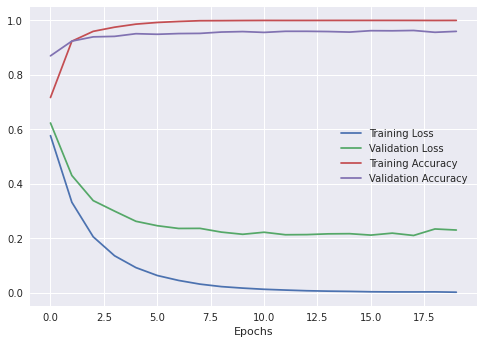

In [10]:
with plt.style.context('seaborn'):    
    plt.plot(train_losses,label='Training Loss')
    plt.plot(val_losses,label='Validation Loss')
    plt.plot(train_accuracies,label='Training Accuracy')
    plt.plot(val_accuracies,label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
plt.show()

In [11]:
# testing validation bias
model.eval()
val_predictions = []
with torch.no_grad():
    for X_val, y_val,_ in val_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        val_out = model(X_val)
        val_pred = torch.round(torch.sigmoid(val_out)).detach().cpu().numpy().flatten()
        val_predictions.append(val_pred)

In [12]:
val_predictions = np.array(val_predictions).flatten()
val_df['predictions'] = val_predictions
val_df

,reference_identity,candidate_identity,reference_ethnicity,candidate_ethnicity,reference_gender,candidate_gender,labels,predictions
32083,n006534,n002406,asian,asian,male,male,0.0,0.0
3576,n002241,n002241,black,black,male,male,1.0,1.0
22988,n000931,n002050,black,black,male,male,0.0,0.0
29398,n008322,n008067,indian,indian,male,male,0.0,0.0
35659,n002102,n005907,indian,indian,female,female,0.0,0.0
...,...,...,...,...,...,...,...,...
5141,n003243,n003243,indian,indian,male,male,1.0,1.0
27364,n009033,n000964,white,white,male,male,0.0,0.0
1022,n003463,n003463,asian,asian,male,male,1.0,1.0
5167,n006352,n006352,indian,indian,male,male,1.0,1.0


In [13]:
male_val_df = val_df[val_df['reference_gender']=='male']
female_val_df = val_df[val_df['reference_gender']=='female']

In [14]:

male_val_preds = male_val_df.predictions
female_val_preds = female_val_df.predictions

male_val_labels = male_val_df.labels
female_val_labels = female_val_df.labels


male_tn, male_fp, male_fn, male_tp, male_acc = confusion_mat(male_val_preds,male_val_labels)
female_tn, female_fp, female_fn, female_tp, female_acc = confusion_mat(female_val_preds,female_val_labels)


male_tnr = male_tn/(male_tn+male_fp)
male_tpr = male_tp/(male_tp+male_fn)
male_fnr = male_fn/(male_fn+male_tp)
male_fpr = male_fp/(male_fp+male_tn)
male_balanced_accuracy = (male_tpr + male_tnr)/2

female_tnr = female_tn/(female_tn+female_fp)
female_tpr = female_tp/(female_tp+female_fn)
female_fnr = female_fn/(female_fn+female_tp)
female_fpr = female_fp/(female_fp+female_tn)
female_balanced_accuracy = (female_tpr + female_tnr)/2

print(f'male TNR: {male_tn/(male_tn+male_fp):.3f} | male TPR: {male_tp/(male_tp+male_fn):.3f} ')
print(f'male FNR: {male_fn/(male_fn+male_tp):.3f} | male FPR: {male_fp/(male_fp+male_tn):.3f} ')
print(f'male ACC: {male_acc:.3f} | male balanced ACC: {male_balanced_accuracy:.3f} ')

print(f'female TNR: {female_tn/(female_tn+female_fp):.3f} | female TPR: {female_tp/(female_tp+female_fn):.3f} ')
print(f'female FNR: {female_fn/(female_fn+female_tp):.3f} | female FPR: {female_fp/(female_fp+female_tn):.3f} ')
print(f'female ACC: {female_acc:.3f} | female balanced ACC: {female_balanced_accuracy:.3f} ')

male TNR: 0.943 | male TPR: 0.977 
male FNR: 0.023 | male FPR: 0.057 
male ACC: 0.960 | male balanced ACC: 0.960 
female TNR: 0.951 | female TPR: 0.968 
female FNR: 0.032 | female FPR: 0.049 
female ACC: 0.959 | female balanced ACC: 0.960 


In [15]:
torch.save(model,'weights/bfw_senet50_logistic_regression_face_matching_'+str(beta)+'_beta_TEST.pt')